In [7]:
import pandas as pd
import glob
import os
import janitor
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

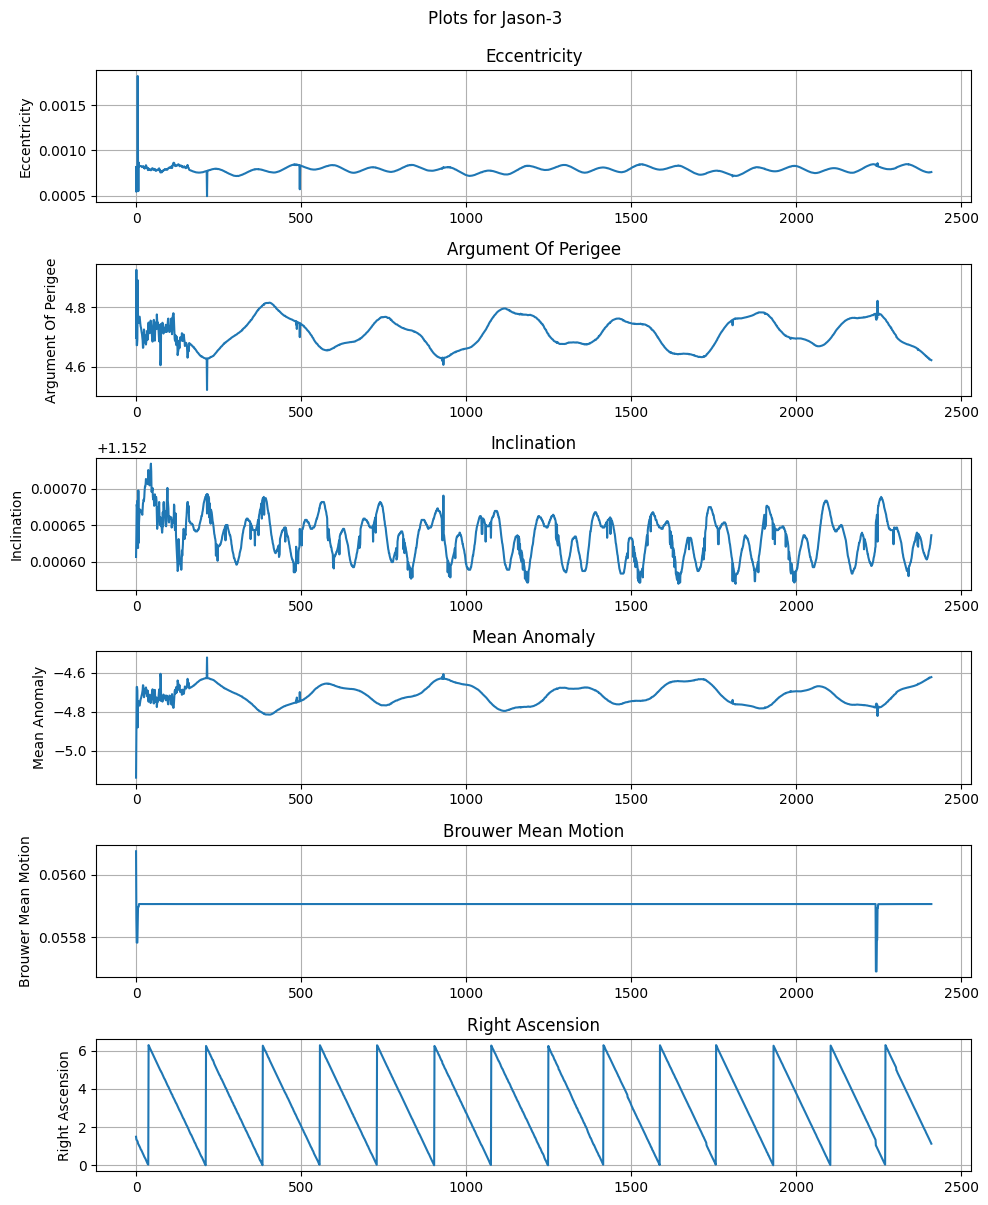

In [8]:
# Location to the file containing the csv file for the data
csv_file_path = "satellite_data/orbital_elements/unpropagated_elements_Jason-3.csv"

# Function to remove outliers using IQR method
def remove_outliers_iqr(df):
    numeric_df = df.select_dtypes(include = ['float64','int64'])
    Q1 = numeric_df.quantile(0.25)
    Q3 = numeric_df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = numeric_df[~((numeric_df < lower_bound) | (numeric_df > upper_bound)).any(axis = 1)]
    return filtered_df

# Reading the csv data file and creating a dataframe
df = pd.read_csv(csv_file_path)

# Converting the column names into snake case for clarity
df = df.clean_names()

# Converting column name unnamed_0 to date_time
df.rename(columns={'unnamed_0':'date_time'}, inplace=True)

# Converting date_time into dattime format
df['date_time'] = pd.to_datetime(df['date_time'])

# Removing outliers from the numeric data
filtered_numeric_df = remove_outliers_iqr(df)

# Recombining the non-numeric data with the filtered numeric data
non_numeric_df = df.select_dtypes(exclude = ['float64','int64'])
filtered_df = pd.concat([filtered_numeric_df, non_numeric_df], axis = 1)

# Setting date_time column as index
filtered_df.set_index('date_time',inplace = True)

columns_to_plot = filtered_df.columns
num_columns = len(columns_to_plot)

# Creating a figure with subplots for each column of data
fig, axes = plt.subplots(nrows = num_columns, ncols = 1, figsize = (10,2*num_columns), sharex = False)

# Plotting each column in its own subplot
for x, column in enumerate(columns_to_plot):
    ax = axes[x]
    df[column].plot(ax = ax, title = column.replace('_',' ').title())
    ax.set_ylabel(column.replace('_',' ').title())
    ax.grid(True)

plt.suptitle("Plots for Jason-3", y = 1)
plt.tight_layout()
plt.subplots_adjust(top = 0.95)
plt.show()

In [9]:
# Defining the format of the maneuver text file
columns_widths = [
    (0,5),      # Satellite Name
    (6,10),     # Begining of manueuver year    
    (11,14),    # Begining of manueuver day       
    (15,17),    # Begining of manueuver hour 
    (18,20),    # Begining of manueuver minute 
    (21,25),    # End of manueuver year 
    (26,29),    # End of manueuver day 
    (30,32),    # End of manueuver hour 
    (33,35),    # End of manueuver minute 
    (36,39),    # Manuever type
    (40,43),    # Manuever parameter type
    (44,45)     # Number of burns
]

# Function to parse each line based on column widths defined
def parse_line(line):
    data = [
        line[start:end].strip()
        for start, end in columns_widths
    ]
    return data

# Function to convert start and end maneuver to datetime
def convert_to_datetime(row):
    start_date = datetime.strptime(f"{row['Start_Year']} {row['Start_Day']} {row['Start_Hour']} {row['Start_Minute']}", "%Y %j %H %M")
    end_date = datetime.strptime(f"{row['End_Year']} {row['End_Day']} {row['End_Hour']} {row['End_Minute']}", "%Y %j %H %M")
    return start_date, end_date

# File path to maneuver file
maneuver_file_path = 'satellite_data/manoeuvres/ja3man.txt'

# Reading the text file into a list of lines
with open(maneuver_file_path, 'r') as txt_file:
    lines = txt_file.readlines()

# Parsing each line into a list of values
parsed_data = [parse_line(line) for line in lines]

# Defining the column names
column_names = [
    'Satellite', 'Start_Year', 'Start_Day', 'Start_Hour', 'Start_Minute',
    'End_Year', 'End_Day', 'End_Hour', 'End_Minute',
    'Maneuver_Type', 'Parameter_Type', 'Number_of_Burns'
]

# Creating a dataframe with the text file data
df = pd.DataFrame(parsed_data, columns = column_names)

# Converting start and end maneuvers to datetime
df['Start_Date'], df['End_Date'] = zip(*df.apply(convert_to_datetime,axis=1))

# Checking the dataframe
print(df.head())

  Satellite Start_Year Start_Day Start_Hour Start_Minute End_Year End_Day  \
0     JASO3       2016       019         22           18     2016     020   
1     JASO3       2016       021         22           39     2016     022   
2     JASO3       2016       028         22           45     2016     029   
3     JASO3       2016       031         21           38     2016     032   
4     JASO3       2016       033         03           35     2016     033   

  End_Hour End_Minute Maneuver_Type Parameter_Type Number_of_Burns  \
0       01         06                          007               2   
1       01         28                          007               2   
2       02         05                          007               2   
3       00         32                          007               2   
4       06         30                          007               2   

           Start_Date            End_Date  
0 2016-01-19 22:18:00 2016-01-20 01:06:00  
1 2016-01-21 22:39:00 2016-0

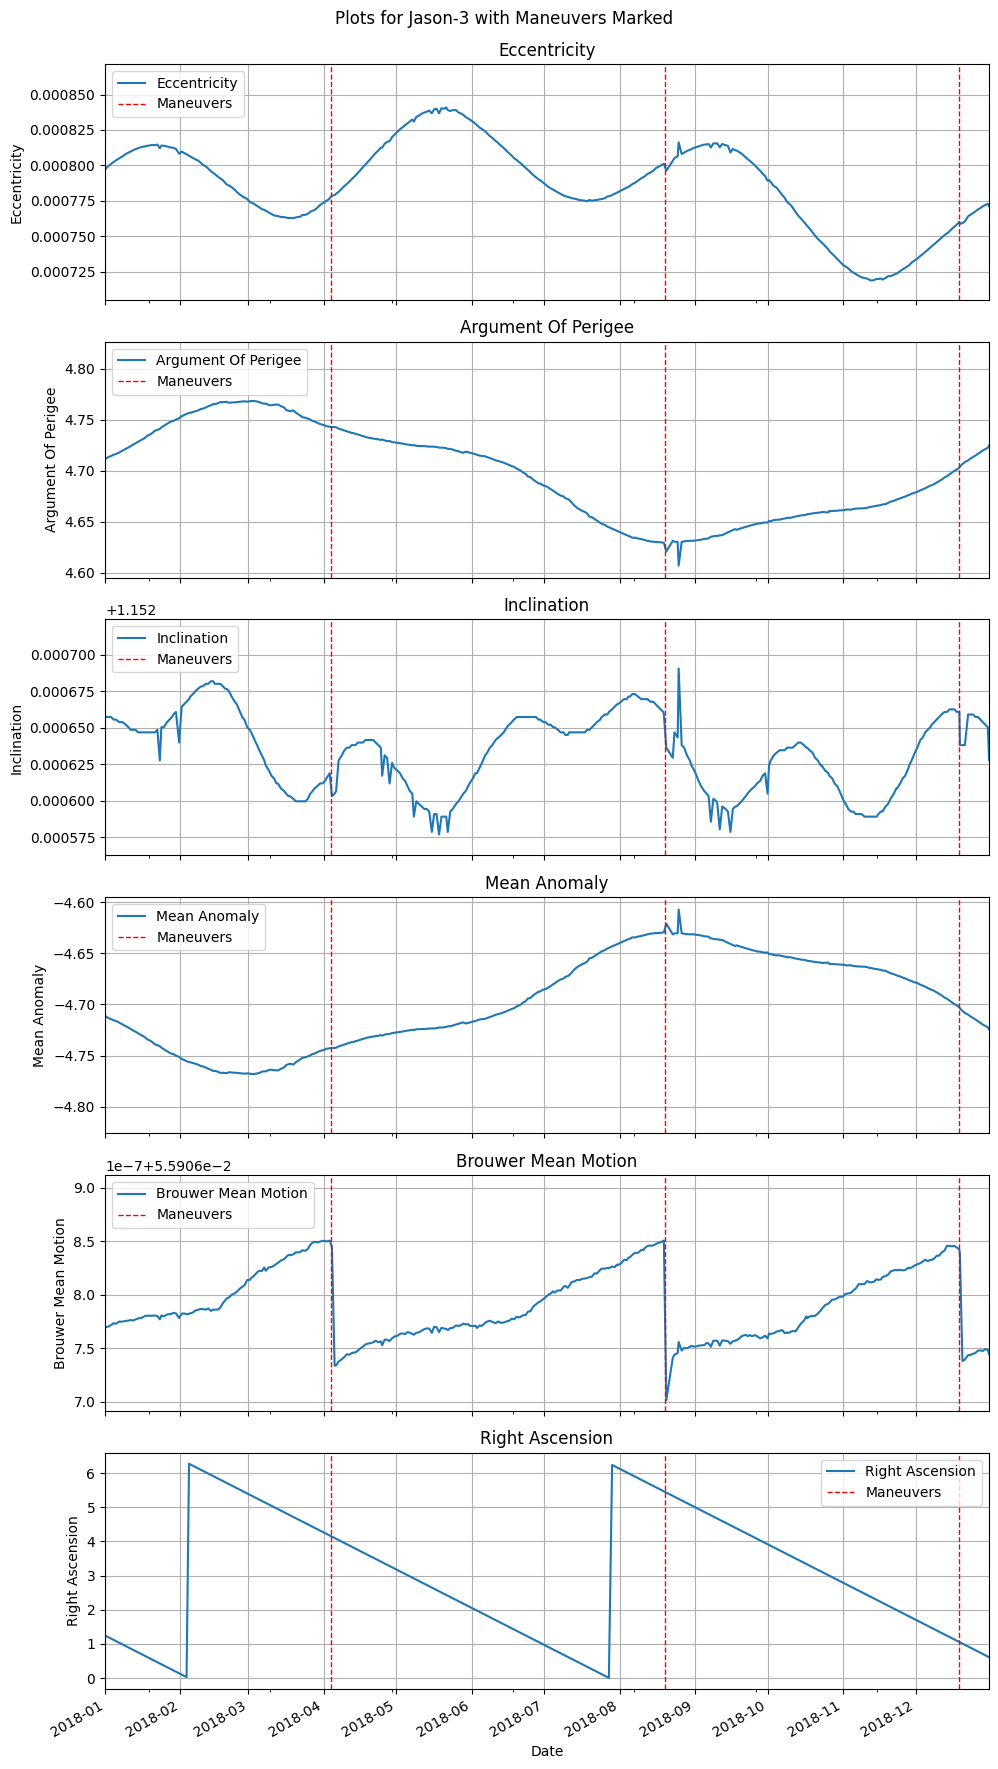

In [10]:
# Function to mark maneuvers on plots
def mark_maneuver_start_on_plot(ax,df):
    for _, row in df.iterrows():
        if pd.notna(row['Start_Date']):
            ax.axvline(x = row['Start_Date'], color = 'red', linestyle = '--', linewidth = 1, label = 'Maneuvers')

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels,handles))
    ax.legend(by_label.values(),by_label.keys())

# Defining the date ranges for the plots
start_date = pd.to_datetime('2018-01-01')
end_date = pd.to_datetime('2018-12-31')

columns_to_plot = filtered_df.columns
num_columns = len(columns_to_plot)

# Creating a figure with subplots for each column of data
fig, axes = plt.subplots(nrows = num_columns, ncols = 1, figsize = (10,3*num_columns), sharex = True)

# Plotting each column in its own subplot
for x, column in enumerate(columns_to_plot):
    ax = axes[x]
    filtered_df[column].plot(ax = ax, title = column.replace('_',' ').title(), label = column.replace('_',' ').title())

    # Marking maneuvers
    mark_maneuver_start_on_plot(ax,df)

    # Setting x axis limits
    ax.set_xlim(start_date,end_date)
    ax.set_xlabel("Date")

    ax.set_ylabel(column.replace('_',' ').title())
    ax.grid(True)

plt.suptitle("Plots for Jason-3 with Maneuvers Marked")
plt.tight_layout()
plt.subplots_adjust(top = 0.95)
plt.show()

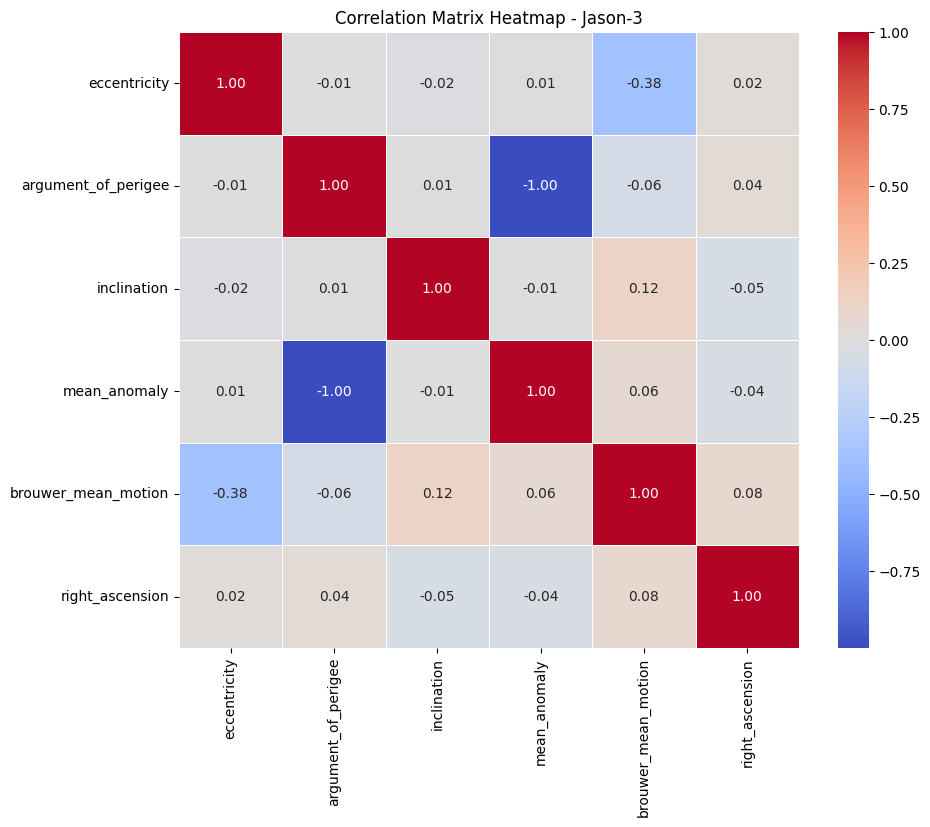

In [11]:
# Calculating the correlation matrix
correlation_matrix = filtered_df.corr()

# Plotting the heatmap for the correlation matrix
plt.figure(figsize = (10,8))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f', linewidths = 0.5)
plt.title("Correlation Matrix Heatmap - Jason-3")
plt.show()